# Graph Training Sandbox

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
sys.path.append('..')

sys.path.append('/global/common/cori_cle7/software/jupyter/19-11/lib/python3.7/site-packages')
sys.path.append('/global/homes/d/danieltm/.local/lib/python3.7/site-packages')

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import seaborn as sns
import wandb
# os.environ['WANDB_MODE'] = 'dryrun'

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Local imports
from utils.toy_utils import *
from datasets.hitgraphs_params import *
%matplotlib inline

## Loading TrackML Dataset

In [6]:
%ls $SCRATCH/ExaTrkX/node_tracker_data/
g1 = np.load("/global/cscratch1/sd/danieltm/ExaTrkX/node_tracker_data/hitgraphs_med_000/event000001000_g000.npz")

hitgraphs_med_000/


In [2]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/node_tracker_data/hitgraphs_med_000/"
filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                         if f.endswith('.npz') and not f.endswith('_ID.npz')]

In [3]:
full_graphs = [load_graph(fi) for fi in filenames]

In [5]:
cut_mask = [~(np.isnan(g[3]).any()) for g in full_graphs]
cut_full_graphs = np.array(full_graphs)[cut_mask].tolist()

In [4]:
cut_full_dataset = [torch_geometric.data.Data(x=torch.from_numpy(di[0]),
                                         edge_index=torch.from_numpy(di[1]), y_edges=torch.from_numpy(di[2]), 
                                         y_params=(torch.from_numpy(di[3][:,0]).unsqueeze(1)), pid=torch.from_numpy(di[4])) for di in full_graphs]

## Visualise data

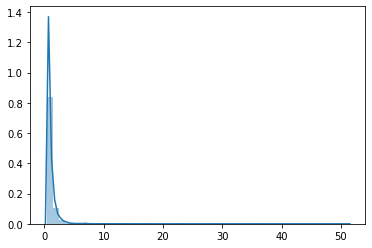

In [49]:
sns.distplot(np.concatenate(np.array([di[3][:,0] for di in full_graphs]))[:100000])

## Constructing PyG Datastructure

In [5]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [6]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-3)

Using  cuda


## Edge Classification Testing

In [51]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

Epoch:  1 , loss:  0.5512356758117676 , accuracy:  0.6864395625058761
Epoch:  2 , loss:  0.5046652555465698 , accuracy:  0.7436710645899276
Epoch:  3 , loss:  0.48637688159942627 , accuracy:  0.7629634272462315
Epoch:  4 , loss:  0.47630026936531067 , accuracy:  0.7705349587890564
Epoch:  5 , loss:  0.4798726439476013 , accuracy:  0.7736814064997336
Epoch:  6 , loss:  0.4695682227611542 , accuracy:  0.7731611770973706
Epoch:  7 , loss:  0.4612908959388733 , accuracy:  0.7738506377511047
Epoch:  8 , loss:  0.44322115182876587 , accuracy:  0.7768779968034097
Epoch:  9 , loss:  0.46184107661247253 , accuracy:  0.7758438058228087
Epoch:  10 , loss:  0.43595728278160095 , accuracy:  0.7730358206148735
Epoch:  11 , loss:  0.40324726700782776 , accuracy:  0.7812466702184336
Epoch:  12 , loss:  0.3373474180698395 , accuracy:  0.7961014133943402
Epoch:  13 , loss:  0.27982667088508606 , accuracy:  0.8321476699363816
Epoch:  14 , loss:  0.2253979742527008 , accuracy:  0.8571813594910527
Epoch:  

KeyboardInterrupt: 

In [52]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    pred = model(data)
    correct = ((pred > 0.5) == (data.y > 0.5)).sum().item()
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5930], edge_index=[2, 14580], x=[5930, 2], y=[14580])
Accuracy: 0.9812
Batch(batch=[5880], edge_index=[2, 14637], x=[5880, 2], y=[14637])
Accuracy: 0.9832
Batch(batch=[5580], edge_index=[2, 14190], x=[5580, 2], y=[14190])
Accuracy: 0.9862
Batch(batch=[5710], edge_index=[2, 14652], x=[5710, 2], y=[14652])
Accuracy: 0.9838
Batch(batch=[5470], edge_index=[2, 12952], x=[5470, 2], y=[12952])
Accuracy: 0.9866


## Track Count Testing


In [9]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

Using  cuda


In [12]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        out = model(data)
        _, pred = out.max(dim=1)
        print(pred.shape, data.y.shape, pred, data.y)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        
        correct += float(pred.eq(data.y).sum().item())
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6], device='cuda:0') tensor([ 9,  9,  7,  4,  7,  3,  5,  7,  6,  7,  4,  7,  2,  6,  5,  6,  7,  9,
         5,  9,  6,  9,  5,  7,  8,  8,  4,  4,  7,  5,  6,  4,  4,  8, 10,  1,
         5,  8,  8,  5,  8,  4,  9,  5,  9,  6,  2,  9,  5,  4,  7,  4,  9,  5,
         9,  5,  5,  4,  9,  6,  5,  7,  6,  4,  7,  4, 11,  4, 11,  5,  7,  4,
         7,  7,  9,  5,  3,  7,  3,  6,  3,  8,  3,  6,  6,  4,  6,  4,  8,  3,
         7,  7,  8,  2,  6,  6,  3,  4,  8,  2], device='cuda:0')
torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6

KeyboardInterrupt: 

In [23]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    _, pred = model(data).max(dim=1)
    print(pred, data.y)
    correct = float(pred.eq(data.y).sum().item())
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[6110], edge_index=[2, 16297], x=[6110, 2], y=[100])
tensor([ 7,  7,  7,  4,  6,  4,  6,  9,  7,  9,  8,  2,  5,  6,  5,  6,  7,  7,
         9,  7,  4,  7,  9,  9,  5,  8,  5,  5,  4,  9,  7,  4,  9,  3,  9,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  5,  4,  5,  5, 10,  5,  2,  7,  9,  6,
        10,  4,  3,  9,  4,  9,  4,  8,  6,  9,  9,  5,  1,  9,  7,  9,  5,  4,
         9,  6,  4,  9,  4,  4,  3,  7,  7,  9,  4,  4,  3,  7,  7,  4,  6,  9,
         7,  9, 10,  7,  9,  4, 10,  5,  7,  6], device='cuda:0') tensor([ 7,  7,  8,  4,  6,  4,  5, 11,  8, 10,  8,  3,  5,  6,  4,  6,  7,  6,
         8,  7,  4,  7,  9,  8,  5,  8,  5,  5,  2, 10,  7,  5,  9,  2,  8,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  6,  5,  5,  6, 10,  5,  2,  6,  7,  6,
        11,  4,  3,  9,  3,  9,  4,  8,  6,  8,  6,  6,  2,  8,  7,  8,  5,  4,
         6,  5,  3,  9,  4,  3,  3,  6,  8, 10,  5,  4,  3,  7,  9,  4,  6,  5,
         7,  9,  9,  7, 10,  4, 11,  5,  6,  6], device='cuda:0')
Acc

## Combined Counter & Classifier

In [8]:
train_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [9]:
train_dataset[0].y_graph.item()

6

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Edge_Graph_Class_Net(input_dim=2, hidden_dim=16, n_graph_iters=4, output_dim=12).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Using  cuda


In [23]:
model.train()
loss_v = []
acc_v_count = []
acc_v_edge = []
ep = 0
for epoch in range(500):
    ep += 1
    count_correct = 0
    edge_correct = 0
    count_total = 0
    edge_total = 0 
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        edge_pred, graph_pred = model(data)
        _, graph_pred_max = graph_pred.max(dim=1)
        losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y.float()), F.cross_entropy(graph_pred, data.y_graph)]
#         print(losses[0].item(), losses[1].item())
        loss = sum(losses)
        loss.backward()
        optimizer.step()

        edge_correct += ((edge_pred > 0.5) == (data.y > 0.5)).sum().item()
        count_correct += float(graph_pred_max.eq(data.y_graph).sum().item())
#         print(correct, pred, data.y)
        count_total += len(graph_pred_max)
        edge_total += len(edge_pred)
#         print(out, data.y, )
    count_acc = count_correct/count_total
    edge_acc = edge_correct / edge_total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", count accuracy: ", count_acc, ", edge accuracy: ", edge_acc)
    loss_v.append(loss)
    acc_v_count.append(count_acc)
    acc_v_edge.append(edge_acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v_count)), acc_v_count)
plt.plot(np.arange(len(acc_v_edge)), acc_v_edge)
plt.ylim(0.1,1)

Epoch:  1 , loss:  3.1576285362243652 , count accuracy:  0.122 , edge accuracy:  0.6513064133016627
Epoch:  2 , loss:  3.1742045879364014 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  3 , loss:  3.0324511528015137 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  4 , loss:  3.011707305908203 , count accuracy:  0.158 , edge accuracy:  0.6614945111382166
Epoch:  5 , loss:  3.0208494663238525 , count accuracy:  0.196 , edge accuracy:  0.6620851255055531
Epoch:  6 , loss:  3.003718137741089 , count accuracy:  0.182 , edge accuracy:  0.6734865506837003
Epoch:  7 , loss:  2.8945674896240234 , count accuracy:  0.193 , edge accuracy:  0.6919881877126532
Epoch:  8 , loss:  2.9283816814422607 , count accuracy:  0.194 , edge accuracy:  0.7084547730628491
Epoch:  9 , loss:  2.8948309421539307 , count accuracy:  0.204 , edge accuracy:  0.7297875072221865
Epoch:  10 , loss:  2.914076328277588 , count accuracy:  0.208 , edge accuracy:  0.746857546382487
Epo

KeyboardInterrupt: 

In [11]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    edge_pred, graph_pred = model(data)
    _, graph_pred_max = graph_pred.max(dim=1)
    correct = float(graph_pred_max.eq(data.y_graph).sum().item())
    acc = correct / len(graph_pred_max)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5910], edge_index=[2, 14768], x=[5910, 2], y=[14768], y_graph=[100])
Accuracy: 0.6900
Batch(batch=[6130], edge_index=[2, 15735], x=[6130, 2], y=[15735], y_graph=[100])
Accuracy: 0.7000
Batch(batch=[6460], edge_index=[2, 17175], x=[6460, 2], y=[17175], y_graph=[100])
Accuracy: 0.6700
Batch(batch=[6180], edge_index=[2, 15944], x=[6180, 2], y=[15944], y_graph=[100])
Accuracy: 0.6800
Batch(batch=[6110], edge_index=[2, 15557], x=[6110, 2], y=[15557], y_graph=[100])
Accuracy: 0.8600


## Combined Edge & Track Param Classifier

How to do a double scatter...

In [5]:
class TwoHopAttNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                 layer_norm=True):
        super(TwoHopAttNetwork, self).__init__()
        self.network = make_mlp(input_dim*5, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mi2 = scatter_add(e[:, None]*scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        mo2 = scatter_add(e[:, None]*scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mi2, mo, mo2, x], dim=1)
        return self.network(node_inputs)

class TwoHopNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                 layer_norm=True):
        super(TwoHopNetwork, self).__init__()
        self.network = make_mlp(input_dim*5, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(x[start], end, dim=0, dim_size=x.shape[0])
        mi2 = scatter_add(scatter_add(x[start], end, dim=0, dim_size=x.shape[0])[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(x[end], start, dim=0, dim_size=x.shape[0])
        mo2 = scatter_add(scatter_add(x[end], start, dim=0, dim_size=x.shape[0])[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mi2, mo, mo2, x], dim=1)
        return self.network(node_inputs)

class Edge_Track_Net(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
        super(Edge_Track_Net, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      hidden_activation=nn.ReLU,
                                      layer_norm=False)
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = TwoHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                        hidden_activation=nn.ReLU, layer_norm=False)
        
#         self.output_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, output_dim,
#                                         layer_norm=False)
        self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, hidden_dim, output_dim],
                                       hidden_activation=nn.ReLU,
                                      output_activation=None,
                                      layer_norm=False)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        e = self.edge_network(x, inputs.edge_index)
        return e, self.output_network(x)
    
class Edge_Track_Truth_Net(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
        super(Edge_Track_Truth_Net, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      hidden_activation=nn.ReLU,
                                      layer_norm=False)
        # Setup the node layers
        self.node_network = TwoHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                        hidden_activation=nn.ReLU, layer_norm=False)
        
#         self.output_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, output_dim,
#                                         layer_norm=False)
        self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, hidden_dim, output_dim],
                                       hidden_activation=nn.ReLU,
                                      output_activation=None,
                                      layer_norm=False)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = inputs.y_edges
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        return self.output_network(x)

#### Generate data

#### Load data

In [6]:
train_size = int(0.5 * len(cut_full_dataset))
test_size = int(0.1 * len(cut_full_dataset))
train_dataset = cut_full_dataset[:train_size]
test_dataset = cut_full_dataset[-test_size:]
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
t_configs = {'train_size': train_size, 'test_size': test_size}

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
m_configs = {'input_dim': 3, 'hidden_dim': 16, 'n_graph_iters': 3, 'output_dim': 1}
model = Edge_Track_Truth_Net(**m_configs).to(device)
# data = dataset[0].to(device)
o_configs = {'lr': 0.001, 'weight_decay': 1e-4}
# optimizer = torch.optim.SGD([
#                                 {'params': model.input_network.parameters()},
#                                 {'params': model.edge_network.parameters()},
#                                 {'params': model.node_network.parameters()},
#                                 {'params': model.output_network.parameters(), 'lr': learning_rate*10}], lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam([
#                                 {'params': model.input_network.parameters()},
#                                 {'params': model.edge_network.parameters()},
#                                 {'params': model.node_network.parameters(), 'lr': learning_rate*10},
#                                 {'params': model.output_network.parameters(), 'lr': learning_rate*10}], lr=learning_rate, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), **o_configs)
s_configs = {'step_size': 20, 'gamma': 0.9}
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **s_configs)

Using  cuda


In [9]:
hyperconfig = {**m_configs, **t_configs, **s_configs, **o_configs}
wandb.init(project="node_regression", config=hyperconfig)
wandb.watch(model, log='all')

wandb: Network error resolved after 0:00:23.785435, resuming normal operation.
wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


wandb: Network error resolved after 0:00:11.332204, resuming normal operation.
wandb: Network error resolved after 0:00:23.334204, resuming normal operation.
wandb: Network error resolved after 0:00:37.807275, resuming normal operation.
wandb: Network error resolved after 0:00:38.484777, resuming normal operation.


In [16]:
!wandb

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/bin/wandb", line 6, in <module>
    from wandb.cli import cli
ModuleNotFoundError: No module named 'wandb'


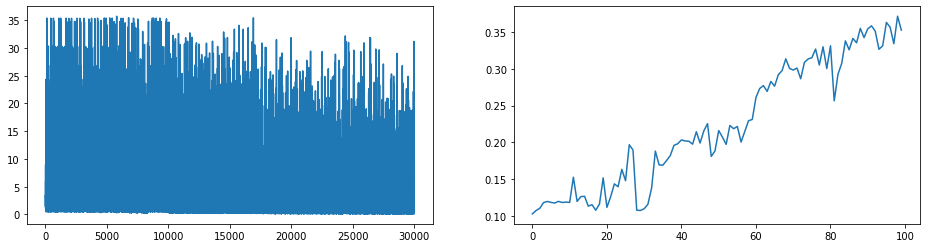

In [47]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,4)
axs[0].plot(np.arange(len(loss_v_node)), loss_v_node)
# axs[1].plot(np.arange(len(loss_v_edge)), loss_v_edge)
axs[1].plot(np.arange(len(acc_v_node)), acc_v_node)
# axs[3].plot(np.arange(len(acc_v_edge)), acc_v_edge)

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Network error resolved after 0:00:11.345432, resuming normal operation.
Failed to connect to W&B servers after 10 seconds.                    Letting user process proceed while attempting to reconnect.


Epoch:  1 , loss:  0.6007898449897766 , node accuracy:  10.242046834801204 %, lr:  [0.001]


Retry attempt failed:
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connectionpool.py", l

Epoch:  2 , loss:  0.817642867565155 , node accuracy:  10.806555227684166 %, lr:  [0.001]
Epoch:  3 , loss:  0.9038619995117188 , node accuracy:  11.966084468880512 %, lr:  [0.001]
Epoch:  4 , loss:  2.6982123851776123 , node accuracy:  12.011629412664599 %, lr:  [0.001]
Epoch:  5 , loss:  2.588160753250122 , node accuracy:  11.906975326302884 %, lr:  [0.001]
Epoch:  6 , loss:  1.5540924072265625 , node accuracy:  11.722250515928984 %, lr:  [0.001]


wandb: Network error resolved after 0:00:58.266933, resuming normal operation.


Epoch:  7 , loss:  8.183475494384766 , node accuracy:  11.767347980989985 %, lr:  [0.001]
Epoch:  8 , loss:  1.7046161890029907 , node accuracy:  11.827561836665232 %, lr:  [0.001]


wandb: Network error resolved after 0:00:11.470606, resuming normal operation.


Epoch:  9 , loss:  0.42751920223236084 , node accuracy:  11.777570073070478 %, lr:  [0.001]
Epoch:  10 , loss:  2.032323122024536 , node accuracy:  11.7880718393529 %, lr:  [0.001]


wandb: ERROR Error uploading "config.yaml": CommError, <Response [400]>
Retry attempt failed:
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/global/homes/d/danieltm/.local/cori/pyt

Epoch:  11 , loss:  0.9068647623062134 , node accuracy:  11.77572422333775 %, lr:  [0.001]
Epoch:  12 , loss:  3.974558115005493 , node accuracy:  11.754566869961844 %, lr:  [0.001]
Epoch:  13 , loss:  0.7298269271850586 , node accuracy:  11.784953472001396 %, lr:  [0.001]
Epoch:  14 , loss:  0.7682395577430725 , node accuracy:  11.689500666883134 %, lr:  [0.001]
Epoch:  15 , loss:  5.155138969421387 , node accuracy:  11.852173166434957 %, lr:  [0.001]


wandb: Network error resolved after 0:00:56.379144, resuming normal operation.


Epoch:  16 , loss:  2.4475228786468506 , node accuracy:  11.88984528143475 %, lr:  [0.001]
Epoch:  17 , loss:  8.945351600646973 , node accuracy:  11.948003531725822 %, lr:  [0.001]
Epoch:  18 , loss:  0.800361692905426 , node accuracy:  11.82655500953829 %, lr:  [0.001]
Epoch:  19 , loss:  4.170938968658447 , node accuracy:  12.117542032934994 %, lr:  [0.001]
Epoch:  20 , loss:  13.88068675994873 , node accuracy:  11.96797226974353 %, lr:  [0.0009000000000000001]
Epoch:  21 , loss:  9.681962013244629 , node accuracy:  12.113640577818089 %, lr:  [0.0009000000000000001]
Epoch:  22 , loss:  4.359136581420898 , node accuracy:  12.098664024304808 %, lr:  [0.0009000000000000001]
Epoch:  23 , loss:  0.9145486354827881 , node accuracy:  12.054405581849592 %, lr:  [0.0009000000000000001]
Epoch:  24 , loss:  1.0942814350128174 , node accuracy:  12.114088056541174 %, lr:  [0.0009000000000000001]
Epoch:  25 , loss:  1.8272830247879028 , node accuracy:  12.160220316149312 %, lr:  [0.00090000000000

wandb: ERROR Error uploading "diff.patch": CommError, <Response [400]>


Epoch:  28 , loss:  1.0357260704040527 , node accuracy:  12.188509361674399 %, lr:  [0.0009000000000000001]
Epoch:  29 , loss:  5.578948974609375 , node accuracy:  12.176371501310692 %, lr:  [0.0009000000000000001]
Epoch:  30 , loss:  7.798847675323486 , node accuracy:  12.258595716677728 %, lr:  [0.0009000000000000001]
Epoch:  31 , loss:  6.776310920715332 , node accuracy:  12.162583563155609 %, lr:  [0.0009000000000000001]
Epoch:  32 , loss:  0.6156641840934753 , node accuracy:  12.182356529231967 %, lr:  [0.0009000000000000001]
Epoch:  33 , loss:  0.6728848814964294 , node accuracy:  12.12583437302218 %, lr:  [0.0009000000000000001]
Epoch:  34 , loss:  3.6187450885772705 , node accuracy:  12.225244568097732 %, lr:  [0.0009000000000000001]
Epoch:  35 , loss:  3.693549633026123 , node accuracy:  12.218280680469707 %, lr:  [0.0009000000000000001]
Epoch:  36 , loss:  2.0439088344573975 , node accuracy:  12.09069330954984 %, lr:  [0.0009000000000000001]
Epoch:  37 , loss:  2.483504533767

Retry attempt failed:
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
OSError: [Errno 101] Network is unreachable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/con

Epoch:  47 , loss:  1.369815468788147 , node accuracy:  12.232641950738746 %, lr:  [0.0008100000000000001]
Epoch:  48 , loss:  29.94580841064453 , node accuracy:  12.380771391790276 %, lr:  [0.0008100000000000001]
Epoch:  49 , loss:  18.640899658203125 , node accuracy:  14.612893148513434 %, lr:  [0.0008100000000000001]
Epoch:  50 , loss:  2.596501350402832 , node accuracy:  10.714682252350592 %, lr:  [0.0008100000000000001]
Epoch:  51 , loss:  2.0275228023529053 , node accuracy:  11.03620969859791 %, lr:  [0.0008100000000000001]
Epoch:  52 , loss:  3.6572177410125732 , node accuracy:  11.914134985872257 %, lr:  [0.0008100000000000001]
Epoch:  53 , loss:  0.4805273115634918 , node accuracy:  12.153172526260708 %, lr:  [0.0008100000000000001]
Epoch:  54 , loss:  3.2910521030426025 , node accuracy:  12.409647753139414 %, lr:  [0.0008100000000000001]
Epoch:  55 , loss:  1.5877015590667725 , node accuracy:  13.966789807217776 %, lr:  [0.0008100000000000001]
Epoch:  56 , loss:  0.7358959913

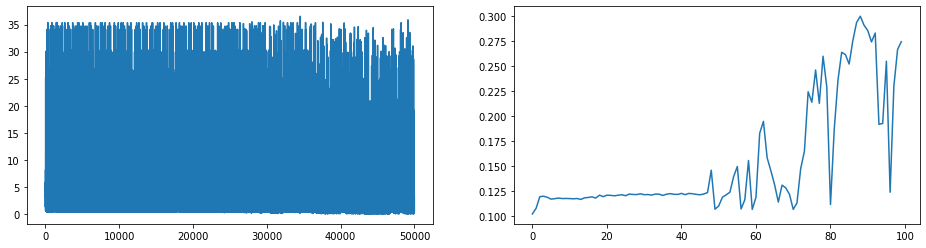

wandb: Network error resolved after 0:00:23.512588, resuming normal operation.


In [10]:
model.train()
loss_v_node = []
# loss_v_edge = []
acc_v_node = []
# acc_v_edge = []
ep = 0
for epoch in range(100):
    ep += 1
    node_correct = 0
#     edge_correct = 0
    node_total = 0
#     edge_total = 0 
    for batch in train_loader:
#         print(batch)
        optimizer.zero_grad()
        data = batch.to(device)
        node_pred = model(data)
#         print(edge_pred.shape, data.y_edges.shape, node_pred.shape, data.y_params.shape)
#         print(edge_pred, data.y_edges, node_pred, data.y_params)
#         losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y_edges.float()), F.mse_loss(node_pred.float(), data.y_params.float())]
#         print(node_pred, data.y_nodes)
#         print("Losses: ", losses[0].item(), losses[1].item())
        loss = F.mse_loss(node_pred, data.y_params)
#         loss = sum(losses)
#         loss_v_edge.append(losses[0])
        loss_v_node.append(loss)
        loss.backward()
        optimizer.step()
#         edge_pred = torch.sigmoid(edge_pred)
#         edge_correct += ((edge_pred > 0.5) == (data.y_edges > 0.5)).sum().item()
        # A "correct" track parameter is one where the pred. is within 5% of the truth
#         print(node_pred, data.y_nodes)
#         print((((node_pred - data.y_nodes)/data.y_nodes)**2 < 0.05**2).sum().item())
        node_correct += (((node_pred - data.y_params)/data.y_params)**2 < 0.1**2).sum().item()
        node_total += len(node_pred)
#         edge_total += len(edge_pred)
#         print(out, data.y, )
    node_acc = node_correct/node_total
#     edge_acc = edge_correct / edge_total
    scheduler.step()
#     print("Epoch: " , ep, ", loss: ", loss.item(), ", node accuracy: ", node_acc*100, "%, edge accuracy: ", edge_acc*100, "%, lr: ", scheduler.get_lr())
    print("Epoch: " , ep, ", loss: ", loss.item(), ", node accuracy: ", node_acc*100, "%, lr: ", scheduler.get_lr())
    acc_v_node.append(node_acc)
    wandb.log({"Test Accuracy": node_acc, "Test Loss": loss.item(), "Learning Rate": scheduler.get_lr()[0]})
#     acc_v_edge.append(edge_acc)

#     if node_acc > 0.5:
#         break
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,4)
axs[0].plot(np.arange(len(loss_v_node)-10), loss_v_node[10:])
# axs[1].plot(np.arange(len(loss_v_edge)-10), loss_v_edge[10:])
axs[1].plot(np.arange(len(acc_v_node)), acc_v_node)
# axs[3].plot(np.arange(len(acc_v_edge)), acc_v_edge)

In [52]:
model.eval()
for batch in test_loader:
#     print(batch)
    data = batch.to(device)
    node_pred = model(data)
#     edge_pred = torch.sigmoid(edge_pred)
#     print(edge_pred, data.y_edges, node_pred, data.y_params)
    print(node_pred, data.y_params)
#     edge_correct = ((edge_pred > 0.5) == (data.y_edges > 0.5)).sum().item()
    correct = (((node_pred - data.y_params)/data.y_params)**2 < 0.1**2).sum().item()
    acc = correct / (len(node_pred))*100
#     edge_acc = edge_correct / len(edge_pred)*100
#     print('Accuracy: {:.4f}%'.format(acc), ', edge accuracy: {:.4f}%'.format(edge_acc))
    print('Accuracy: {:.4f}%'.format(acc))

tensor([[ 8.9318],
        [11.8650],
        [11.2290],
        ...,
        [ 0.7272],
        [ 0.6703],
        [ 0.7702]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[15.2125],
        [15.2125],
        [15.2125],
        ...,
        [ 0.5958],
        [ 0.5958],
        [ 0.5958]], device='cuda:0')
Accuracy: 39.7417%
tensor([[13.8930],
        [14.0282],
        [17.2821],
        ...,
        [ 1.9400],
        [ 1.5565],
        [ 1.8785]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[40.8148],
        [40.8148],
        [40.8148],
        ...,
        [ 1.7936],
        [ 1.7936],
        [ 1.7936]], device='cuda:0')
Accuracy: 40.2185%
tensor([[0.6895],
        [0.6651],
        [0.6577],
        ...,
        [1.0724],
        [1.4556],
        [1.4310]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[18.9864],
        [18.9864],
        [18.9864],
        ...,
        [ 0.6766],
        [ 0.6766],
        [ 0.6766]], device='cuda:0')
Accuracy: 40.0350%
tens

        [0.6972]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[34.2068],
        [34.2068],
        [34.2068],
        ...,
        [ 0.5591],
        [ 0.5591],
        [ 0.5591]], device='cuda:0')
Accuracy: 40.2999%
tensor([[10.2161],
        [ 8.5189],
        [ 7.6812],
        ...,
        [ 0.6470],
        [ 0.6614],
        [ 0.5862]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[12.3305],
        [12.3305],
        [12.3305],
        ...,
        [ 0.5768],
        [ 0.5768],
        [ 0.5768]], device='cuda:0')
Accuracy: 40.0605%
tensor([[0.9681],
        [1.0175],
        [1.0679],
        ...,
        [0.6423],
        [0.6531],
        [0.6582]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[2.1535],
        [2.1535],
        [2.1535],
        ...,
        [0.5419],
        [0.5419],
        [0.5419]], device='cuda:0')
Accuracy: 39.3605%
tensor([[0.9883],
        [0.9892],
        [0.9956],
        ...,
        [0.7058],
        [0.7919],
        [0.9199]

tensor([[0.9016],
        [1.0014],
        [1.2399],
        ...,
        [0.6275],
        [0.6268],
        [0.6755]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1.0432],
        [1.0432],
        [1.0432],
        ...,
        [0.6954],
        [0.6954],
        [0.6954]], device='cuda:0')
Accuracy: 39.1318%
tensor([[0.9803],
        [0.9692],
        [0.9925],
        ...,
        [0.5200],
        [0.5255],
        [0.5377]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[5.4676],
        [5.4676],
        [5.4676],
        ...,
        [0.5036],
        [0.5036],
        [0.5036]], device='cuda:0')
Accuracy: 39.6506%
tensor([[19.0480],
        [23.0835],
        [21.6653],
        ...,
        [ 1.5495],
        [ 1.5566],
        [ 1.3213]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[66.0761],
        [66.0761],
        [66.0761],
        ...,
        [ 1.1489],
        [ 1.1489],
        [ 1.1489]], device='cuda:0')
Accuracy: 39.7656%
tensor([[10.7145],
   

In [42]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()
print(torch.cuda.memory_allocated(0)/1024**3, torch.cuda.max_memory_allocated(0)/1024**3)

13.484405994415283 13.484405994415283


## Getting Weights & Bias to Work

In [18]:
model.output_network

Sequential(
  (0): Linear(in_features=19, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

Retry attempt failed:
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
OSError: [Errno 101] Network is unreachable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/con